In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from multiprocessing import Process, Pool
from threading import Thread
import time
import timeit
%matplotlib inline

# Nacteni dat

In [2]:
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.json",'r') as f:
    items = json.loads(f.read())

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/properties.json",'r') as f:
    properties = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/user.folds.json",'r') as f:
    user_folds = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.int2str.json",'r') as f:
    users_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.str2int.json",'r') as f:
    users_str2int = json.loads(f.read())
      
ratings = pd.read_csv('/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/ratings.csv')

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.int2str.json",'r') as f:
    items_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.str2int.json",'r') as f:
    items_str2int = json.loads(f.read())

# Faktorizace

In [3]:
import multiprocessing
import ctypes
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sparse_lg

In [4]:
import numpy as np
from numpy.linalg import inv
# %load_ext line_profiler

In [7]:
class MatrixFactorization:
    def __init__(self, ratings, no_factors):
        self.Ratings = ratings.pivot_table(columns=['userId'],index=['itemId'],values='rating')
        self.Ratings_matrix = np.nan_to_num(self.Ratings.values)
        self.Ratings_matrix_sparse = sp.csr_matrix(self.Ratings_matrix)
        self.Idx = np.isfinite(self.Ratings.values)
        self.ratings_dict = dict(ratings.apply(lambda r:( (str(int(r.userId)),str(int(r.itemId))),{
                                                                    'rating':r.rating,
                                                                     }), axis=1).values)
        self.no_factors = no_factors
        self.Users = None
        self.Items = None
        
    def init(self):
        if(self.weights_mode == "AllRank"):
            self.Weights = np.isfinite(self.Ratings.values).astype(np.float64, copy=False)
            self.Weights[self.Weights==0] = self.weight
            self.Weights_sparse = sp.csr_matrix(self.Weights)
            print("** Set weight: ",self.weight, " to missing ratings **")

        elif(self.weights_mode == "AllRank-pop"):
            pass
        
        elif(self.weights_mode == "MF-RMSE"):
            assert self.weight == 0, "Weight of missiong values MF-RMSE mode must be 0!"
            self.Weights = np.isfinite(self.Ratings.values).astype(np.float64, copy=False)
            self.Weights_sparse = sp.csr_matrix(self.Weights)
            
        if(self.imputation_value != 0 ):   
            self.Ratings_matrix[self.Idx==False] = self.imputation_value
            self.Ratings_matrix_sparse = sp.csr_matrix(self.Ratings_matrix)
            print("** Surrogate missing rating values by imputation value: ", self.imputation_value, " **")
        
        
        if(self.random_init): 
            user_shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[1]* self.no_factors), lock=False)
            user_shared_array = np.frombuffer(user_shared_array_base,dtype=float)    
            self.Users = user_shared_array.reshape(self.Ratings.shape[1], self.no_factors)
            
            
            item_shared_array_base = multiprocessing.Array(ctypes.c_double, np.random.rand(self.Ratings.shape[0] * self.no_factors), lock= False)
            item_shared_array = np.frombuffer(item_shared_array_base,dtype=float)
            self.Items = item_shared_array.reshape(self.Ratings.shape[0], self.no_factors)
            
    '''
    RMSE
    '''  
    def get_error(self, R, U, V, W):
        E = (R - (self.imputation_value + np.dot(V,U.T)))
#         W_ = W[Idx] - self.weight
        return (W * (E**2)).sum()
    
    '''
    OPTIMAZE PER FACTOR
    '''
    
    def compute_item_factor(self, batch):
        W, R, V = self.Weights, self.Ratings_matrix, self.Items
        lambda_, alfa, r_m = self.lambda_, self.alfa, self.imputation_value
        if(self.sparse):
            U = sp.csr_matrix(self.Users)
        else:
            U = self.Users


        if(self.opt_method == "solver"):
            if(self.sparse):
                for i in batch:
                    
                    lM = sp.csr_matrix(R[i,:] - r_m).dot(sp.diags(W[i], 0)).dot(U)
                    rM = (U.T.dot(sp.diags(W[i], 0))).dot(U) + lambda_ * W[i].sum() * sp.eye(self.no_factors)
#                     V[i,:] = lM.dot(sparse_lg.inv(rM)).toarray()[0]
                    V[i,:] = sparse_lg.spsolve(rM,lM.T)
    
            elif(not self.sparse):
                for i in batch:
                    lM = np.dot(np.dot((R[i,:] - r_m),np.diag(W[i,:])),U)
                    rM = np.dot(np.dot(U.T,np.diag(W[i,:])),U) + lambda_ * W[i,:].sum() * np.eye(self.no_factors) #np.dot(np.trace(np.diag(W[i,:])),np.eye(self.no_factors))
                    V[i,:] = np.dot(lM, inv(rM))
#                     V[i,:] = np.linalg.solve(rM,lM)

        if(self.opt_method == "gradient-descent"):
            for i in batch:
                for c in range(50):
                    V[i] += -alfa * (np.dot((np.dot(V[i], U[Idx[i,:],:].T) - R[i,Idx[i,:]]), U[Idx[i,:],:]) + lambda_ * V[i]) #TODO pri AllRank je to spatne: Brat v uvahu vsechny hodnoceni 
        return
    
    def compute_user_factor(self, batch):
        W, R, U = self.Weights, self.Ratings_matrix, self.Users
        lambda_, alfa, r_m = self.lambda_, self.alfa, self.imputation_value
        if(self.sparse):
            V = sp.csr_matrix(self.Items)
        else:
            V = self.Items

        if(self.opt_method == "solver"):
            if(self.sparse):
                for u in batch:
                    lM = sp.csr_matrix(R[:,u].T - r_m).dot(sp.diags(W[:,u], 0)).dot(V)
                    rM = (V.T.dot(sp.diags(W[:,u], 0))).dot(V) + lambda_ * W[:,u].sum() * sp.eye(self.no_factors)
#                     U[u,:] = lM.dot(sparse_lg.inv(rM)).toarray()[0]
                    U[u,:] = sparse_lg.spsolve(rM,lM.T)
    
            elif(not self.sparse):
                for u in batch:
                    lM = np.dot(np.dot(R[:,u].T - r_m, np.diag(W[:,u])), V)
                    rM = np.dot(np.dot(V.T,np.diag(W[:,u])), V) + lambda_ * W[:,u].sum() * np.eye(self.no_factors) #np.dot(np.trace(np.diag(W[:,u]))
                    U[u,:] = np.dot(lM, inv(rM))
#                     U[u,:] = np.linalg.solve(rM,lM)

        if(self.opt_method == "gradient-descent"):
             for u in batch:
                for c in range(50):
                    U[u] += -alfa * (np.dot((np.dot(U[u], V[Idx[:,u],:].T) - R[Idx[:,u], u].T), V[Idx[:,u],:]) + lambda_* U[u] ) #TODO pri AllRank je to spatne: Brat v uvahu vsechny hodnoceni 
    
        return
    '''
    OPTIMIZE RMSE
    '''
    def optimize_rmse(self):
        
        self.init()
        weighted_errors = []

        step_item = int(np.ceil(len(self.Items)/float(self.no_process)))
        step_user = int(np.ceil(len(self.Users)/float(self.no_process)))
        
        item_range = [range(i,min(len(self.Items), i+step_item)) for i in range(0, len(self.Items), step_item)]
        user_range = [range(i,min(len(self.Users), i+step_user)) for i in range(0, len(self.Users), step_user)]
        print("Item range", item_range)
        print("User range", user_range)
        
        for ii in range(self.no_iterations):
            if(not ii % 1):
                weighted_errors.append(self.get_error(self.Ratings_matrix, self.Users, self.Items, self.Weights))
                print('{}th iteration is completed'.format(ii))
                print(weighted_errors[-1])
                self.R_hat = np.dot(self.Users, self.Items.T)

            #ITEMS                
            process = []
            for batch in item_range:
                p = Process(target = self.compute_item_factor, args = (batch,))
                p.daemon = True

                process.append(p)
                p.start()
            
            [p.join() for p in process]
                
            #USERS
            process = []
            for batch in user_range:
                p = Process(target = self.compute_user_factor, args = (batch,))
                p.daemon = True

                process.append(p)
                p.start()
            
            [p.join() for p in process]


        return weighted_errors

        
    def optimaze(self, no_iterations, loss_function="RMSE", opt_method="solver",  lambda_ = 0.001, alfa=0.00001, 
                 no_process = 1, random_init = True, weights_mode = "MF-RMSE", weight = 0, imputation_value = 0, sparse = False):
        
        self.loss_function = loss_function
        self.solve_opt_method = opt_method 
        self.lambda_ = lambda_
        self.alfa = alfa
        self.no_process = no_process
        self.no_iterations = no_iterations
        self.random_init = random_init
        self.weights_mode = weights_mode
        self.weight = weight
        self.imputation_value = imputation_value
        self.opt_method = opt_method
        self.sparse = sparse
        
        weighted_errors = self.optimize_rmse()
        self.plot_rmse(weighted_errors)
        
    '''
    PLOT AND EXPLORE
    '''
    def plot_rmse(self, weighted_errors):
        plt.plot(np.log(weighted_errors), label="weighted error: "+str(weighted_errors[-1]))
        plt.ylabel("RMSE log scale")
        plt.xlabel("no iterations")

        plt.legend()
        plt.show()
    def explore(self):
        R = self.Ratings_matrix
        no_ratings = np.sum(self.Idx==True)
        no_missing = np.sum(self.Idx==False)
        no_all = no_ratings + no_missing
        
        sizes = [no_ratings, no_missing]
        labels = ["ratings", "missings"]
        colors = ['yellowgreen', 'lightskyblue']

        plt.pie(sizes, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90, colors= colors)
        plt.axis('equal')
        plt.show()
        print("#{} rating, #{} missing".format(no_ratings, no_missing))
        print("Estimate offset w(m): ", no_ratings/no_missing)
        print("Avg of ratings: ", R[self.Idx].mean())
        
        no_relevant = np.sum(R[self.Idx]>=.25)
        no_irelevant = np.sum(R[self.Idx]<.25)
        labels = ["relevant", "irelevenat"]

        sizes = [no_relevant, no_irelevant]
        colors = ['lightskyblue', 'lightcoral']
        plt.pie(sizes, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90, colors= colors)
        plt.axis('equal')
        plt.show()
        
        print("#{} relevant, #{} irelevant".format(no_relevant, no_irelevant))

In [8]:
# %lprun -f MFact.rmse_optimalization MFact.rmse_optimalization(0.001, 0.0001, 5)

In [9]:
import datetime
MFact = MatrixFactorization(ratings.copy(), 100)

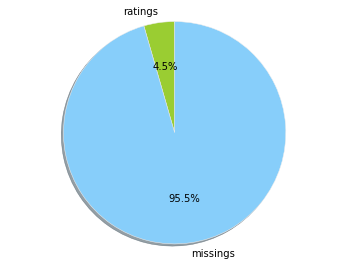

#1000209 rating, #21384031 missing
Estimate offset w(m):  0.0467736415085
Avg of ratings:  0.290782226515


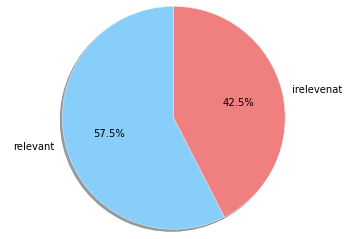

#575281 relevant, #424928 irelevant


In [ ]:
MFact.explore()

In [ ]:
start_time = datetime.datetime.now()
MFact.optimaze(8, opt_method="solver",  alfa = 0.004, no_process = 7, weights_mode = "AllRank", weight = 0.05, imputation_value = 0.1 , random_init = True, sparse = True)
datetime.datetime.now() - start_time

** Set weight:  0.05  to missing ratings **
** Surrogate missing rating values by imputation value:  0.1  **
Item range [range(0, 530), range(530, 1060), range(1060, 1590), range(1590, 2120), range(2120, 2650), range(2650, 3180), range(3180, 3706)]
User range [range(0, 863), range(863, 1726), range(1726, 2589), range(2589, 3452), range(3452, 4315), range(4315, 5178), range(5178, 6040)]
0th iteration is completed
1291870742.05
